<a href="https://colab.research.google.com/github/andremonroy/stanWeinstein/blob/main/Simplificado_WMA_10_y_30_entradas%2C_salidas%2C_backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Backtesting Estrategia Stan Weinstein (Fase 1 → Fase 2)

Este notebook implementa el framework de *scoring* y backtesting semanal que definiste, usando `pandas`, `numpy`, `matplotlib` y `yfinance`.
Incluye:
- Cálculo de **WMA30** y su **pendiente**
- Detección de **bases/consolidaciones**
- **RS vs benchmark** y pendiente del RS
- **Resistencias** (últimos 2 y 10 años / ATH 10 años)
- Análisis de **volumen** en la base
- Detección de **breakout** con volumen
- Sistema de **scoring (0–10)**
- **Backtest** con reglas de entrada (score ≥ 8) y salida (WMA30 con pendiente negativa)
- **Métricas** (CAGR, Sharpe, % ganadoras, MaxDD, etc.) y gráficos (score, equity curve, ejemplo de base+ruptura).

> **Requisitos**: conexión a Internet para descargar datos con `yfinance`.


In [1]:
#Celda 1
# === Instalación (si hace falta) ===
!pip install yfinance pandas numpy matplotlib scipy tqdm


In [2]:
#Celda 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
from tqdm import tqdm
import math

plt.rcParams['figure.figsize'] = (12, 6)
pd.options.display.float_format = '{:,.4f}'.format


## Utilidades

In [3]:
#Celda 3
def to_weekly(df: pd.DataFrame) -> pd.DataFrame:
    """Resample diario → semanal (OHLCV). Semana cierra el viernes."""
    if not df.index.inferred_type == 'datetime64':
        df = df.set_index(pd.to_datetime(df['Date']))
    o = df['Open'].resample('W-FRI').first()
    h = df['High'].resample('W-FRI').max()
    l = df['Low'].resample('W-FRI').min()
    c = df['Close'].resample('W-FRI').last()
    v = df['Volume'].resample('W-FRI').sum()
    out = pd.DataFrame({'Open': o, 'High': h, 'Low': l, 'Close': c, 'Volume': v})
    out.dropna(inplace=True)
    out['Date'] = out.index
    return out

def WMA(series: pd.Series, window: int) -> pd.Series:
    """Weighted Moving Average con pesos lineales 1..window (más peso a lo reciente)."""
    weights = np.arange(1, window+1, dtype=float)
    def f(x):
        return np.dot(x, weights) / weights.sum()
    return series.rolling(window).apply(f, raw=True)

def pct_change_safe(series: pd.Series, periods=1):
    return series.pct_change(periods=periods).replace([np.inf, -np.inf], np.nan)

def rolling_max_drawdown(equity: pd.Series) -> float:
    """Calculates the maximum drawdown of an equity curve.
    Returns 0.0 if the equity curve is empty or only increasing.
    """
    # Debugging prints
    # print("\nDebugging rolling_max_drawdown:")
    # print("Equity series head:")
    # print(equity.head())
    # print("Equity series tail:")
    # print(equity.tail())
    # print(f"Equity series shape: {equity.shape}")


    if equity.empty:
        # print("Equity is empty, returning 0.0")
        return 0.0
    peak = equity.cummax()
    # Debugging: Print peak series
    # print("Peak series head:")
    # print(peak.head())
    # print("Peak series tail:")
    # print(peak.tail())

    # Calculate drawdown relative to peak
    drawdown = (equity/peak - 1.0)
    # Debugging: Print drawdown series
    # print("Drawdown series head:")
    # print(drawdown.head())
    # print("Drawdown series tail:")
    # print(drawdown.tail())

    # Handle cases where equity is constantly increasing (no drawdown) - min drawdown will be >= 0
    min_drawdown = drawdown.min()
    # Debugging: Print min_drawdown
    # print(f"Minimum drawdown calculated: {min_drawdown}")

    if min_drawdown >= 0:
        # print("Minimum drawdown >= 0, returning 0.0")
        return 0.0
    # Max Drawdown is the absolute value of the minimum drawdown
    mdd = min_drawdown
    # Debugging: Print final MaxDD
    # print(f"Final MaxDrawdown calculated: {mdd}")

    # Ensure the return type is float
    return float(mdd)


def sharpe_ratio(returns: pd.Series, periods_per_year=52, rf=0.0) -> float:
    excess = returns - rf/periods_per_year
    if excess.std(ddof=0) == 0 or np.isnan(excess.std(ddof=0)):
        return np.nan
    return np.sqrt(periods_per_year) * excess.mean() / excess.std(ddof=0)

def CAGR(equity: pd.Series, periods_per_year=52) -> float:
    if equity.empty or equity.iloc[0] == 0:
        return np.nan
    # Ensure we have at least one full period to calculate CAGR
    if len(equity) < 2:
        return np.nan
    total_return = equity.iloc[-1] / equity.iloc[0] - 1.0
    years = len(equity) / periods_per_year
    if years <= 0:
        return np.nan
    return (1+total_return)**(1/years) - 1

def recent_swing_highs(series: pd.Series, lookback: int = 104, order: int = 3) -> pd.Series:
    """Aproximación: puntos que son máximos locales (swing highs)."""
    # Máximo local simple: mayor que vecinos +/- order
    highs = series.copy()
    mask = pd.Series(False, index=series.index)
    for i in range(order, len(series)-order):
        if series.iloc[i] == series.iloc[i-order:i+order+1].max():
            mask.iloc[i] = True
    return series.where(mask)

def nearest_resistance_above(price: float, swings: pd.Series) -> Optional[float]:
    vals = swings.dropna()
    candidates = vals[vals > price]
    return candidates.min() if not candidates.empty else np.nan

def ath(series: pd.Series, lookback: int) -> float:
    return series.tail(lookback).max()

## Criterios de Score

In [4]:
#Celda 4
@dataclass
class ScoreComponents:
    wma30_slope: int
    base_strength: int
    rs: int
    resistance: int
    volume_pattern: int
    breakout: int
    total: int

def compute_wma30_and_slope(w: pd.DataFrame) -> Tuple[pd.Series, pd.Series, pd.Series]:
    w['WMA30'] = WMA(w['Close'], 30)
    # Pendiente semanal como % (WMA vs WMA -1)
    w['WMA30_slope_pct'] = pct_change_safe(w['WMA30'])
    # Discretización: negativa=0, plana (-0.1%..+0.1%)=2, positiva=1
    cond_neg = w['WMA30_slope_pct'] < -0.001
    cond_flat = (w['WMA30_slope_pct'] >= -0.001) & (w['WMA30_slope_pct'] <= 0.001)
    slope_score = pd.Series(1, index=w.index)
    slope_score[cond_neg] = 0
    slope_score[cond_flat] = 2
    return w['WMA30'], w['WMA30_slope_pct'], slope_score

def detect_current_base(w: pd.DataFrame, max_lookback=60, volat_threshold=0.10) -> Tuple[pd.Series, pd.Series, pd.Series]:
    """Para cada semana t, estima si está en base: rango % en ventana que *termina* en t.
    Devuelve: base_len, base_volatility, base_high (techo).
    """
    base_len = pd.Series(0, index=w.index, dtype=int)
    base_vol = pd.Series(np.nan, index=w.index, dtype=float)
    base_high = pd.Series(np.nan, index=w.index, dtype=float)
    for i in range(len(w)):
        # explorar ventanas que terminen en i, hasta max_lookback
        best_len = 0; best_vol = np.nan; best_high = np.nan
        for L in range(5, min(max_lookback, i)+1):
            win = w.iloc[i-L+1:i+1]
            mx, mn = win['Close'].max(), win['Close'].min()
            mid = (mx+mn)/2.0
            volat = (mx-mn)/mid if mid != 0 else np.nan
            if volat <= volat_threshold:
                best_len = L; best_vol = volat; best_high = mx
        if best_len > 0:
            base_len.iloc[i] = best_len
            base_vol.iloc[i] = best_vol
            base_high.iloc[i] = best_high
    return base_len, base_vol, base_high

def score_base_strength(base_len: pd.Series, base_vol: pd.Series) -> pd.Series:
    s = pd.Series(0, index=base_len.index, dtype=int)
    s[(base_len >= 5) & (base_len < 15)] = 1
    s[(base_len >= 15) & (base_len <= 40) & (base_vol < 0.10)] = 2
    return s

def compute_RS(asset_close: pd.Series, bench_close: pd.Series, lookback_weeks: int = 26) -> Tuple[pd.Series, pd.Series, pd.Series]:
    """RS(t) = retorno log acumulado asset - benchmark en ventana lookback.
    RS_slope: pendiente semanal del RS (dif primera).
    RS score: 0 si cayendo, 2 si RS<0 pero pendiente positiva >=3 semanas, 1 si RS>0 y subiendo.
    """
    asset_ret = np.log(asset_close / asset_close.shift(lookback_weeks))
    bench_ret = np.log(bench_close / bench_close.shift(lookback_weeks))
    RS = asset_ret - bench_ret
    RS_diff = RS.diff()
    # condición "subiendo": RS_diff > 0
    up = RS_diff > 0
    # Pendiente positiva >= 3 semanas consecutivas
    pos3 = up.rolling(3).apply(lambda x: 1 if np.all(x==1) else 0, raw=True).fillna(0) == 1
    score = pd.Series(0, index=RS.index, dtype=int)
    score[(RS < 0) & pos3] = 2
    score[(RS > 0) & up] = 1
    return RS, RS_diff, score

def score_resistance(w: pd.DataFrame, years_2=104, years_10=520, near_ath_pct=0.05) -> pd.Series:
    """Evalúa la distancia a la resistencia más cercana (swing high) por encima del precio actual,
    usando últimos 2 años y 10 años. Si no hay resistencia (porque está cerca de ATH 10 años),
    se considera 'cerca de ATH'.
    Reglas:
      - <10% arriba -> 0
      - 10–20% -> 1
      - >=20% o cerca del ATH(10y) -> 2
    """
    sh_2y = recent_swing_highs(w['High'], lookback=years_2)
    sh_10y = recent_swing_highs(w['High'], lookback=years_10)
    s = pd.Series(0, index=w.index, dtype=int)
    for i in range(len(w)):
        price = w['Close'].iloc[i]
        # Buscar resistencia 2 años (más relevante operativamente)
        r2 = nearest_resistance_above(price, sh_2y.iloc[max(0,i-years_2):i+1])
        # Chequear ATH 10 años
        ath10 = ath(w['High'].iloc[max(0,i-years_10):i+1], lookback=min(years_10, i+1))
        near_ath = not np.isnan(ath10) and (ath10 - price)/ath10 <= near_ath_pct
        if near_ath:
            s.iloc[i] = 2
        else:
            if np.isnan(r2):
                # sin resistencia identificable arriba en 2 años → fallback 10 años
                r10 = nearest_resistance_above(price, sh_10y.iloc[max(0,i-years_10):i+1])
                target = r10
            else:
                target = r2
            if np.isnan(target):
                # tampoco hay por encima → interpretar como cielo despejado
                s.iloc[i] = 2
            else:
                dist = (target/price) - 1.0
                if dist < 0.10:
                    s.iloc[i] = 0
                elif dist < 0.20:
                    s.iloc[i] = 1
                else:
                    s.iloc[i] = 2
    return s

def score_volume_pattern(w: pd.DataFrame, base_len: pd.Series) -> pd.Series:
    """Analiza el volumen durante bases:
    - 2 puntos:
        volumen medio en el último cuarto de la base > 20% al de la primera mitad (expansión al final)
    - 1 punto:
        volumen medio de la base < promedio de 52 semanas (seco/decreciente)
    - 0 puntos: desordenado
    """
    s = pd.Series(0, index=w.index, dtype=int)
    vol52 = w['Volume'].rolling(52).mean()
    for i in range(len(w)):
        L = base_len.iloc[i]
        if L >= 5:
            win = w['Volume'].iloc[i-L+1:i+1]
            half = max(1, L//2)
            qtr = max(1, L//4)
            first_half = win.iloc[:half].mean()
            last_q = win.iloc[-qtr:].mean()
            if first_half > 0 and last_q / first_half >= 1.2:
                s.iloc[i] = 2
            elif win.mean() < vol52.iloc[i]:
                s.iloc[i] = 1
            else:
                s.iloc[i] = 0
    return s

def detect_breakout(w: pd.DataFrame, base_high: pd.Series, vol_mult: float = 2.0, vol_window: int = 10) -> pd.Series:
    """Breakout si Close rompe el techo de la base con Volumen >= vol_mult * promedio(vol_window)."""
    vol_avg = w['Volume'].rolling(vol_window).mean()
    cond = (w['Close'] > base_high) & (w['Volume'] >= vol_mult * vol_avg)
    return cond.fillna(False).astype(int)

def assemble_score(w_slope: pd.Series, base_strength: pd.Series, rs_score: pd.Series,
                   resist_score: pd.Series, vol_score: pd.Series, breakout_flag: pd.Series) -> pd.Series:
    total = w_slope.fillna(0).astype(int) +             base_strength.fillna(0).astype(int) +             rs_score.fillna(0).astype(int) +             resist_score.fillna(0).astype(int) +             vol_score.fillna(0).astype(int) +             (2 * breakout_flag.fillna(0).astype(int))  # Breakout cuenta como 2
    return total.clip(lower=0, upper=10)


## Pipeline por ticker

In [5]:
#Celda 5
def process_ticker_weekly(ticker: str, benchmark: str = 'SPY', start: str = '2010-01-01') -> Dict[str, pd.DataFrame]:
    # Descarga datos (Close ya ajustado con auto_adjust=True)
    data = yf.download(ticker, start=start, auto_adjust=True, progress=False)
    if data.empty:
        raise ValueError(f"Sin datos para {ticker}")
    data = data.reset_index()
    data.rename(columns=lambda s: s.title(), inplace=True)  # estandarizar nombres
    w = to_weekly(data)

    # Benchmark
    bench = yf.download(benchmark, start=start, auto_adjust=True, progress=False)
    if bench.empty:
        raise ValueError(f"Sin datos para benchmark {benchmark}")
    bench = bench.reset_index()
    bench.rename(columns=lambda s: s.title(), inplace=True)
    wb = to_weekly(bench)

    # Alinear por intersección de fechas (más robusto que .loc[w.index])
    w = w.set_index('Date')
    wb = wb.set_index('Date')
    common_idx = w.index.intersection(wb.index)
    if len(common_idx) == 0:
        raise ValueError(f"No hay fechas comunes entre {ticker} y {benchmark}")
    w = w.loc[common_idx].copy()
    wb = wb.loc[common_idx].copy()

    # Indicadores
    WMA30, WMA30_slope_pct, slope_score = compute_wma30_and_slope(w.copy())
    base_len, base_vol, base_high = detect_current_base(w.copy())
    base_score = score_base_strength(base_len, base_vol)
    RS, RS_diff, RS_score = compute_RS(w['Close'], wb['Close'])
    resist_score = score_resistance(w)
    vol_score = score_volume_pattern(w, base_len)
    breakout = detect_breakout(w, base_high)

    score_total = assemble_score(slope_score, base_score, RS_score, resist_score, vol_score, breakout)

    out = w.copy()
    out['WMA30'] = WMA30
    out['WMA30_slope_pct'] = WMA30_slope_pct
    out['BaseLen'] = base_len
    out['BaseVol'] = base_vol
    out['BaseHigh'] = base_high
    out['RS'] = RS
    out['RS_diff'] = RS_diff
    out['RS_score'] = RS_score
    out['Resist_score'] = resist_score
    out['Vol_score'] = vol_score
    out['Breakout'] = breakout
    out['Score'] = score_total
    out['BenchClose'] = wb['Close']  # ya alineado por common_idx

    # Debugging: Print dataframes and series before creating 'out'
    # print(f"\nDebugging data for {ticker} before creating 'out' DataFrame:")
    # print("w head:")
    # display(w.head())
    # print("WMA30 head:")
    # display(WMA30.head())
    # print("base_len head:")
    # display(base_len.head())
    # print("RS head:")
    # display(RS.head())
    # print("score_total head:")
    # display(score_total.head())
    # print("wb['Close'] head:")
    # display(wb['Close'].head())


    return {'data': out}

## Backtest (entrada score ≥ 8; salida cuando WMA30 pendiente negativa)

In [6]:
#Celda 6
@dataclass
class Trade:
    entry_date: pd.Timestamp
    entry_price: float
    exit_date: pd.Timestamp
    exit_price: float
    ret: float
    max_dd: float

def backtest_from_scores(df: pd.DataFrame, entry_score: int = 8) -> Tuple[pd.Series, List[Trade]]:
    """Estrategia long-only por ticker:
      - Entrada: semana donde Score cruza desde < entry_score a >= entry_score y Breakout==1
      - Salida: primera semana donde WMA30_slope_pct < -0.001 (pendiente negativa)
      - Capital completamente invertido o en cash (sin piramidación)
    Devuelve curva de equity normalizada a 1.0 y lista de trades.
    """
    close = df['Close']
    slope = df['WMA30_slope_pct']
    score = df['Score']
    breakout = df['Breakout'] == 1

    in_pos = False
    entry_px = None
    entry_idx = None
    equity = pd.Series(index=df.index, dtype=float)
    equity.iloc[0] = 1.0
    trades: List[Trade] = []
    peak_equity = 1.0
    open_date = None

    for i in range(1, len(df)):
        date = df.index[i]
        prev_score = score.iloc[i-1]
        now_score = score.iloc[i]
        # Señal de compra
        buy_signal = (prev_score < entry_score) and (now_score >= entry_score) and breakout.iloc[i]
        sell_signal = (slope.iloc[i] < -0.001)

        if not in_pos and buy_signal:
            in_pos = True
            entry_px = close.iloc[i]
            entry_idx = i
            open_date = date

        if in_pos and sell_signal:
            # cerrar trade
            exit_px = close.iloc[i]
            trade_slice = close.iloc[entry_idx:i+1]
            # max drawdown del trade en términos de precio (no equity)
            peak = trade_slice.cummax()
            dd = (trade_slice/peak - 1.0).min()
            trades.append(Trade(entry_date=open_date, entry_price=entry_px,
                                exit_date=date, exit_price=exit_px,
                                ret=exit_px/entry_px - 1.0, max_dd=dd))
            in_pos = False
            entry_px = None
            entry_idx = None
            open_date = None

        # Actualizar equity
        if in_pos:
            equity.iloc[i] = equity.iloc[i-1] * (close.iloc[i]/close.iloc[i-1])
        else:
            equity.iloc[i] = equity.iloc[i-1]

    # Si queda posición abierta, cerrarla al final
    if in_pos and entry_idx is not None:
        exit_px = close.iloc[-1]
        trade_slice = close.iloc[entry_idx:]
        peak = trade_slice.cummax()
        dd = (trade_slice/peak - 1.0).min()
        trades.append(Trade(entry_date=open_date, entry_price=entry_px,
                            exit_date=df.index[-1], exit_price=exit_px,
                            ret=exit_px/entry_px - 1.0, max_dd=dd))
    return equity, trades

def metrics_from_equity(equity: pd.Series, periods_per_year=52) -> Dict[str, float]:
    rets = equity.pct_change().fillna(0)
    return {
        'CAGR': CAGR(equity, periods_per_year),
        'Sharpe': sharpe_ratio(rets, periods_per_year),
        'MaxDrawdown': rolling_max_drawdown(equity),
        'TotalReturn': equity.iloc[-1]/equity.iloc[0]-1.0
    }


## Ejecución para múltiples tickers y comparación contra benchmark

In [7]:
# ----- CELDA 7 – Función principal de estrategia 10 con 30 - Version simple -----

def run_strategy(tickers, start, end, benchmark='SPY'):
    results = {}

    for ticker in tqdm(tickers, desc="Processing tickers"):
        try:
            data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)
            if data.empty:
                print(f"⚠️ No hay datos para {ticker}")
                continue

            # Ensure index is DatetimeIndex
            if not isinstance(data.index, pd.DatetimeIndex):
                 data.index = pd.to_datetime(data.index)

            # Lógica de estrategia (cruce SMA10 vs SMA30)
            data['SMA10'] = data['Close'].rolling(10).mean()
            data['SMA30'] = data['Close'].rolling(30).mean()

            # Generate buy/sell signals (simple crossover)
            # Buy when SMA10 crosses above SMA30
            data['Buy_Signal'] = (data['SMA10'].shift(1) <= data['SMA30'].shift(1)) & (data['SMA10'] > data['SMA30'])
            # Sell when SMA10 crosses below SMA30
            data['Sell_Signal'] = (data['SMA10'].shift(1) >= data['SMA30'].shift(1)) & (data['SMA10'] < data['SMA30'])

            # Determine position (long = 1, cash = 0)
            data['Position'] = 0.0
            # Apply signals sequentially to determine position
            in_position = False
            for i in range(len(data)):
                if data['Buy_Signal'].iloc[i]:
                    in_position = True
                elif data['Sell_Signal'].iloc[i]:
                    in_position = False
                # Use .loc for setting values by index
                data.loc[data.index[i], 'Position'] = 1.0 if in_position else 0.0


            # Shift position by 1 to trade on the next bar after the signal
            data['Position'] = data['Position'].shift(1).fillna(0)

            # Count trades
            # A trade is completed when a sell signal occurs after a buy signal
            # Or when a buy signal occurs if already in position (would close short and go long, but this is long-only)
            # In a simple long-only strategy, each buy signal followed by a sell signal is one completed trade cycle.
            # We'll count buy signals that lead to entering a position.
            trade_count = data['Buy_Signal'].sum() # Count the number of times we enter a long position


            data['Returns'] = data['Close'].pct_change()
            data['Strategy'] = data['Returns'] * data['Position']

            # Calculate equity curve
            equity = (1 + data['Strategy']).cumprod()
            # Ensure the first non-NaN value is 1.0 using ffill and then fill initial NaNs with 1.0
            equity = equity.ffill().fillna(1.0)
            data['Equity'] = equity


            # Métricas
            # Use the Equity curve for metrics
            # Ensure equity curve is not all NaNs before calculating metrics
            if data['Equity'].first_valid_index() is not None:
                # Use .loc for index-based access
                start_equity_date = data['Equity'].first_valid_index()
                cagr = CAGR(data['Equity'].loc[start_equity_date:], periods_per_year=52) # Use the CAGR function
                sharpe = sharpe_ratio(data['Strategy'].loc[start_equity_date:], periods_per_year=52) # Use the sharpe_ratio function
                mdd = rolling_max_drawdown(data['Equity'].loc[start_equity_date:]) # Use the rolling_max_drawdown function
                total_return = data['Equity'].iloc[-1] / data['Equity'].loc[start_equity_date] - 1.0
            else:
                cagr = np.nan
                sharpe = np.nan
                mdd = np.nan
                total_return = np.nan


            metrics_dict = {
                'CAGR': cagr,
                'Sharpe': sharpe,
                'MaxDD': mdd,
                'TotalReturn': total_return # Add TotalReturn
            }

            # Benchmark
            bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)
            if bench.empty:
                 print(f"⚠️ No hay datos para benchmark {benchmark} para {ticker}")
                 bench_dict = {
                     'CAGR': np.nan, 'Sharpe': np.nan, 'MaxDD': np.nan, 'TotalReturn': np.nan
                 }
                 bench_equity = pd.Series([], dtype=float)
            else:
                # Ensure index is DatetimeIndex
                if not isinstance(bench.index, pd.DatetimeIndex):
                     bench.index = pd.to_datetime(bench.index)

                bench['Returns'] = bench['Close'].pct_change()
                # Calculate benchmark equity
                bench_equity = (1 + bench['Returns']).cumprod()
                # Ensure the first non-NaN value is 1.0 using ffill and then fill initial NaNs with 1.0
                bench_equity = bench_equity.ffill().fillna(1.0)


                # Ensure benchmark equity curve is not all NaNs before calculating metrics
                if bench_equity.first_valid_index() is not None:
                    # Use .loc for index-based access
                    start_bench_equity_date = bench_equity.first_valid_index()
                    bench_cagr = CAGR(bench_equity.loc[start_bench_equity_date:], periods_per_year=52) # Use the CAGR function
                    bench_sharpe = sharpe_ratio(bench['Returns'].loc[start_bench_equity_date:], periods_per_year=52) # Use the sharpe_ratio function
                    bench_mdd = rolling_max_drawdown(bench_equity.loc[start_bench_equity_date:]) # Use the rolling_max_drawdown function
                    bench_total_return = bench_equity.iloc[-1] / bench_equity.loc[start_bench_equity_date] - 1.0 # Add TotalReturn
                else:
                    bench_cagr = np.nan
                    bench_sharpe = np.nan
                    bench_mdd = np.nan
                    bench_total_return = np.nan


                bench_dict = {
                    'CAGR': bench_cagr,
                    'Sharpe': bench_sharpe,
                    'MaxDD': bench_mdd,
                    'TotalReturn': bench_total_return # Add TotalReturn
                }

            # Debugging: Print strategy equity, strategy returns, and metrics_dict before returning
            print(f"\nDebugging data before returning for {ticker}:")
            print("Strategy Equity Tail:")
            display(data['Equity'].tail())
            print("Strategy Returns Tail:")
            display(data['Strategy'].tail())
            print("Metrics Dictionary:")
            print(metrics_dict)


            results[ticker] = {
                'metrics': metrics_dict,
                'bench_metrics': bench_dict,
                'trades': trade_count, # Return the trade count here
                'data': data, # Return the full data with calculations for plotting
                'equity': data['Equity'], # Return strategy equity for plotting
                'bench_equity': bench_equity # Return benchmark equity for plotting
            }

        except Exception as e:
            print(f"Error procesando {ticker}: {e}")
            continue

    return results

## Visualizaciones

In [8]:
#Celda 8
def plot_score(df: pd.DataFrame, ticker: str):
    fig, ax = plt.subplots()
    df['Score'].plot(ax=ax, label='Score')
    ax.axhline(8, linestyle='--', label='Umbral 8')
    ax.set_title(f'Score semanal – {ticker}')
    ax.legend()
    plt.show()

def plot_equity_vs_benchmark(equity: pd.Series, bench_equity: pd.Series, ticker: str):
    fig, ax = plt.subplots()
    equity.plot(ax=ax, label='Estrategia')
    bench_equity.plot(ax=ax, label='Benchmark')
    ax.set_title(f'Equity Curve – {ticker} vs Benchmark')
    ax.legend()
    plt.show()

def plot_base_breakout(df: pd.DataFrame, ticker: str, window: int = 60):
    """Ejemplo de base detectada y ruptura. Muestra velas simples, WMA30 y techo de base."""
    from matplotlib.patches import Rectangle

    # Buscar una semana con breakout
    idxs = df.index[df['Breakout'] == 1]
    if len(idxs) == 0:
        print("No se encontró un breakout en el período.")
        return
    i = df.index.get_loc(idxs[-1])  # último breakout
    i0 = max(0, i - window)
    d = df.iloc[i0:i+1]

    # Velas
    fig, ax = plt.subplots(figsize=(12,6))
    for j, (date, row) in enumerate(d.iterrows()):
        x = j
        o, h, l, c = row['Open'], row['High'], row['Low'], row['Close']
        # cuerpo
        lower, height = (min(o,c), abs(c-o))
        ax.add_patch(Rectangle((x-0.3, lower), 0.6, height))
        # mechas
        ax.vlines(x, l, h)

    ax.plot(range(len(d)), d['WMA30'], label='WMA30')
    ax.hlines(d['BaseHigh'].iloc[-1], xmin=0, xmax=len(d)-1, linestyles='--', label='Techo base')

    ax.set_xticks(range(0, len(d), max(1, len(d)//8)))
    ax.set_xticklabels([d.index[k].strftime('%Y-%m-%d') for k in range(0, len(d), max(1, len(d)//8))], rotation=45)
    ax.set_title(f'{ticker} – Base y ruptura')
    ax.legend()
    plt.tight_layout()
    plt.show()


## Ejecutar con tus tickers

#El objetivo del backtest es medir:

1. CAGR_Strategy → crecimiento anual compuesto si hubieras seguido la estrategia. Bueno si es mayor al benchmark (SPY u otro índice).

Ejemplo: Estrategia CAGR = 18%. Benchmark CAGR = 10% → Tu sistema le gana al mercado.

2. Sharpe_Strategy → ratio riesgo/retorno.
Regla práctica:
    Sharpe < 1 → pobre.
    1 ≤ Sharpe < 2 → aceptable.
    2 ≤ Sharpe < 3 → muy bueno. 3 → excelente

3. MaxDD_Strategy → drawdown máximo (la peor caída desde un pico). Bueno si es menor al benchmark.

3. TotalReturn_Strategy → retorno total.

4. N_Trades → cuántas operaciones ejecutó la estrategia.

👉 Si N_Trades = 0, significa que las reglas nunca se activaron. Entonces esa estrategia no puede evaluarse porque no generó operaciones.

# ¿Cómo interpretarlo?

Si un ticker muestra CAGR_Strategy > CAGR_Bench, la estrategia logró “ganar al mercado”.

Un Sharpe > 1 ya es aceptable, > 2 excelente.

MaxDD bajo (ej. < -20%) indica mejor control de pérdidas.

N_Trades bajo pero con buena CAGR = sistema selectivo pero potente.

En gráficos, confirma que el score subió a ≥8 en bases sólidas y que la salida se dio al deteriorarse la WMA30 (fase 3).

6. Equity Curve vs Benchmark: La curva del capital (estrategia) debería ser más suave, consistente y ascendente que la del benchmark.Si tu curva es muy parecida al benchmark pero con más volatilidad → la estrategia no aporta valor.

In [9]:
# ----- CELDA 9 – Evaluación de tickers (Estrategia Stan Weinstein) -----
from datetime import date
import numpy as np
import pandas as pd

tickers = ['MEDP', 'TBBK', 'PODD', 'HG', 'HNGE', 'AMSC', 'KNSA', 'ALAB', 'ALNT', 'FNV', 'PRM', 'ARX', 'STX', 'RMBS', 'KGC', 'URBN', 'BAP', 'EGO', 'WDC', 'HOOD', 'APH', 'RKLB', 'EXTR', 'NVDA', 'TFPM', 'ANET', 'ATAT', 'FIX', 'OUST', 'WGS', 'LMND', 'LIF', 'RDDT', 'ARQT', 'TARS', 'MIRM', 'HSAI', 'ONC', 'KRMN']
benchmark = 'SPY'
start = '2015-01-01'  # Ajusta si el ticker es más reciente
end = date.today().strftime('%Y-%m-%d') # Define 'end' using today's date

print(f"🔍 Evaluando {len(tickers)} tickers con Estrategia Stan Weinstein...")

results_stan_weinstein = {}

for ticker in tqdm(tickers, desc="Processing tickers"):
    try:
        # Paso 1: Procesar datos y calcular scores usando la pipeline Stan Weinstein (Celda 5)
        processed_data = process_ticker_weekly(ticker, benchmark=benchmark, start=start)
        df_stan_weinstein = processed_data['data']

        # Paso 2: Ejecutar backtest Stan Weinstein (Celda 6)
        equity_stan_weinstein, trades_stan_weinstein = backtest_from_scores(df_stan_weinstein, entry_score=8)

        # Paso 3: Calcular métricas del backtest Stan Weinstein (Celda 6)
        metrics_stan_weinstein = metrics_from_equity(equity_stan_weinstein, periods_per_year=52)

        # Calcular métricas del benchmark (igual que antes, pero asegurando fechas)
        bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)
        if bench.empty:
            bench_metrics = {'CAGR': np.nan, 'Sharpe': np.nan, 'MaxDD': np.nan, 'TotalReturn': np.nan}
            bench_equity = pd.Series([], dtype=float)
        else:
            if not isinstance(bench.index, pd.DatetimeIndex):
                 bench.index = pd.to_datetime(bench.index)
            bench['Returns'] = bench['Close'].pct_change()
            bench_equity = (1 + bench['Returns']).cumprod()
            bench_equity = bench_equity.ffill().fillna(1.0)

            if bench_equity.first_valid_index() is not None:
                start_bench_equity_date = bench_equity.first_valid_index()
                bench_metrics = {
                    'CAGR': CAGR(bench_equity.loc[start_bench_equity_date:], periods_per_year=52),
                    'Sharpe': sharpe_ratio(bench['Returns'].loc[start_bench_equity_date:], periods_per_year=52),
                    'MaxDD': rolling_max_drawdown(bench_equity.loc[start_bench_equity_date:]),
                    'TotalReturn': bench_equity.iloc[-1] / bench_equity.loc[start_bench_equity_date] - 1.0
                }
            else:
                 bench_metrics = {'CAGR': np.nan, 'Sharpe': np.nan, 'MaxDD': np.nan, 'TotalReturn': np.nan}


        results_stan_weinstein[ticker] = {
            'metrics': metrics_stan_weinstein,
            'bench_metrics': bench_metrics,
            'trades': trades_stan_weinstein, # This will contain actual trades for Stan Weinstein
            'data': df_stan_weinstein, # Return the full data with Stan Weinstein calculations
            'equity': equity_stan_weinstein, # Return strategy equity for plotting
            'bench_equity': bench_equity # Return benchmark equity for plotting
        }


    except Exception as e:
        print(f"Error procesando {ticker}: {e}")
        continue

if not results_stan_weinstein:
    print("⚠️ No se obtuvieron resultados para ninguno de los tickers con la Estrategia Stan Weinstein. Revisa mensajes previos.")
else:
    # Mostrar métricas resumidas
    rows = []
    for t, r in results_stan_weinstein.items():
        m = r.get('metrics', {})
        mb = r.get('bench_metrics', {})
        trades = r.get('trades', [])

        if m and mb:
            rows.append({
                'Ticker': t,
                'CAGR_Strategy': m.get('CAGR', np.nan),
                'Sharpe_Strategy': m.get('Sharpe', np.nan),
                'MaxDD_Strategy': float(m.get('MaxDrawdown', np.nan)) if m.get('MaxDrawdown') is not None else np.nan,
                'TotalReturn_Strategy': m.get('TotalReturn', np.nan),
                'CAGR_Bench': mb.get('CAGR', np.nan),
                'Sharpe_Bench': mb.get('Sharpe', np.nan),
                'MaxDD_Bench': float(mb.get('MaxDrawdown', np.nan)) if mb.get('MaxDrawdown') is not None else np.nan,
                'TotalReturn_Bench': mb.get('TotalReturn', np.nan),
                'N_Trades': len(trades)
            })
        else:
             print(f"⚠️ {t}: No se calcularon métricas para la Estrategia Stan Weinstein (probablemente pocos datos o error en el backtest).")


    if rows:
        summary_stan_weinstein = pd.DataFrame(rows).set_index('Ticker').sort_index()
        display(summary_stan_weinstein)
    else:
        print("⚠️ Ningún ticker generó métricas para mostrar con la Estrategia Stan Weinstein.")

🔍 Evaluando 39 tickers con Estrategia Stan Weinstein...


Processing tickers:   3%|▎         | 1/39 [00:00<00:20,  1.83it/s]

Error procesando MEDP: If using all scalar values, you must pass an index


Processing tickers:   5%|▌         | 2/39 [00:00<00:15,  2.38it/s]

Error procesando TBBK: If using all scalar values, you must pass an index


Processing tickers:   8%|▊         | 3/39 [00:01<00:14,  2.46it/s]

Error procesando PODD: If using all scalar values, you must pass an index


Processing tickers:  10%|█         | 4/39 [00:01<00:12,  2.77it/s]

Error procesando HG: If using all scalar values, you must pass an index


Processing tickers:  13%|█▎        | 5/39 [00:01<00:11,  2.91it/s]

Error procesando HNGE: If using all scalar values, you must pass an index


Processing tickers:  15%|█▌        | 6/39 [00:02<00:13,  2.37it/s]

Error procesando AMSC: If using all scalar values, you must pass an index


Processing tickers:  18%|█▊        | 7/39 [00:02<00:11,  2.68it/s]

Error procesando KNSA: If using all scalar values, you must pass an index


Processing tickers:  21%|██        | 8/39 [00:03<00:10,  2.89it/s]

Error procesando ALAB: If using all scalar values, you must pass an index


Processing tickers:  23%|██▎       | 9/39 [00:03<00:12,  2.50it/s]

Error procesando ALNT: If using all scalar values, you must pass an index


Processing tickers:  26%|██▌       | 10/39 [00:04<00:12,  2.31it/s]

Error procesando FNV: If using all scalar values, you must pass an index


Processing tickers:  31%|███       | 12/39 [00:04<00:08,  3.01it/s]

Error procesando PRM: If using all scalar values, you must pass an index
Error procesando ARX: If using all scalar values, you must pass an index


Processing tickers:  33%|███▎      | 13/39 [00:05<00:10,  2.58it/s]

Error procesando STX: If using all scalar values, you must pass an index


Processing tickers:  36%|███▌      | 14/39 [00:05<00:09,  2.73it/s]

Error procesando RMBS: If using all scalar values, you must pass an index


Processing tickers:  38%|███▊      | 15/39 [00:05<00:09,  2.41it/s]

Error procesando KGC: If using all scalar values, you must pass an index


Processing tickers:  41%|████      | 16/39 [00:06<00:09,  2.39it/s]

Error procesando URBN: If using all scalar values, you must pass an index


Processing tickers:  44%|████▎     | 17/39 [00:06<00:09,  2.41it/s]

Error procesando BAP: If using all scalar values, you must pass an index


Processing tickers:  46%|████▌     | 18/39 [00:07<00:09,  2.12it/s]

Error procesando EGO: If using all scalar values, you must pass an index


Processing tickers:  49%|████▊     | 19/39 [00:07<00:10,  1.99it/s]

Error procesando WDC: If using all scalar values, you must pass an index


Processing tickers:  51%|█████▏    | 20/39 [00:08<00:08,  2.21it/s]

Error procesando HOOD: If using all scalar values, you must pass an index


Processing tickers:  54%|█████▍    | 21/39 [00:08<00:08,  2.05it/s]

Error procesando APH: If using all scalar values, you must pass an index


Processing tickers:  56%|█████▋    | 22/39 [00:09<00:07,  2.19it/s]

Error procesando RKLB: If using all scalar values, you must pass an index


Processing tickers:  59%|█████▉    | 23/39 [00:09<00:07,  2.16it/s]

Error procesando EXTR: If using all scalar values, you must pass an index


Processing tickers:  62%|██████▏   | 24/39 [00:10<00:08,  1.86it/s]

Error procesando NVDA: If using all scalar values, you must pass an index


Processing tickers:  64%|██████▍   | 25/39 [00:10<00:06,  2.06it/s]

Error procesando TFPM: If using all scalar values, you must pass an index


Processing tickers:  67%|██████▋   | 26/39 [00:11<00:06,  1.95it/s]

Error procesando ANET: If using all scalar values, you must pass an index


Processing tickers:  69%|██████▉   | 27/39 [00:11<00:05,  2.33it/s]

Error procesando ATAT: If using all scalar values, you must pass an index


Processing tickers:  72%|███████▏  | 28/39 [00:12<00:04,  2.24it/s]

Error procesando FIX: If using all scalar values, you must pass an index


Processing tickers:  74%|███████▍  | 29/39 [00:12<00:04,  2.26it/s]

Error procesando OUST: If using all scalar values, you must pass an index


Processing tickers:  77%|███████▋  | 30/39 [00:12<00:04,  2.23it/s]

Error procesando WGS: If using all scalar values, you must pass an index


Processing tickers:  79%|███████▉  | 31/39 [00:13<00:03,  2.17it/s]

Error procesando LMND: If using all scalar values, you must pass an index


Processing tickers:  82%|████████▏ | 32/39 [00:13<00:02,  2.44it/s]

Error procesando LIF: If using all scalar values, you must pass an index


Processing tickers:  85%|████████▍ | 33/39 [00:14<00:02,  2.58it/s]

Error procesando RDDT: If using all scalar values, you must pass an index


Processing tickers:  87%|████████▋ | 34/39 [00:14<00:02,  2.12it/s]

Error procesando ARQT: If using all scalar values, you must pass an index


Processing tickers:  90%|████████▉ | 35/39 [00:15<00:01,  2.25it/s]

Error procesando TARS: If using all scalar values, you must pass an index


Processing tickers:  95%|█████████▍| 37/39 [00:15<00:00,  3.03it/s]

Error procesando MIRM: If using all scalar values, you must pass an index
Error procesando HSAI: If using all scalar values, you must pass an index


Processing tickers: 100%|██████████| 39/39 [00:15<00:00,  2.45it/s]

Error procesando ONC: If using all scalar values, you must pass an index
Error procesando KRMN: If using all scalar values, you must pass an index
⚠️ No se obtuvieron resultados para ninguno de los tickers con la Estrategia Stan Weinstein. Revisa mensajes previos.



### Notas y supuestos - Celda 9 Estrategia Stan
- **RS**: se usa *outperformance* de 26 semanas (6 meses) como `RS = logret(asset) - logret(benchmark)`; RS>0 indica que el activo superó al benchmark en ese horizonte.
- **Pendiente WMA30**: plana si está entre -0.1% y +0.1% semanal.
- **Base**: se busca una ventana que termine en la semana actual con duración ≥5 y **volatilidad** `(max-min)/mid` ≤ 10%. La mejor ventana encontrada define `BaseLen`, `BaseVol` y `BaseHigh`.
- **Resistencias**: se estiman con *swing highs* simples. Si el precio está dentro de 5% del **ATH de 10 años**, se considera "cerca de ATH".
- **Volumen**:
  - 2 puntos si el promedio del último cuarto de la base > 20% del promedio de la primera mitad (expansión hacia el final).
  - 1 punto si el promedio de la base < promedio de 52 semanas (volumen seco/decreciente).
- **Breakout**: `Close > BaseHigh` con volumen ≥ 2× el promedio de 10 semanas.
- **Entrada**: cruce de `Score` desde <8 a ≥8 **y** `Breakout==1` esa semana.
- **Salida**: cuando la pendiente de WMA30 < -0.1% semanal (inicio Fase 3).
- La lógica es modular para que ajustes umbrales/ventanas a tu estilo.


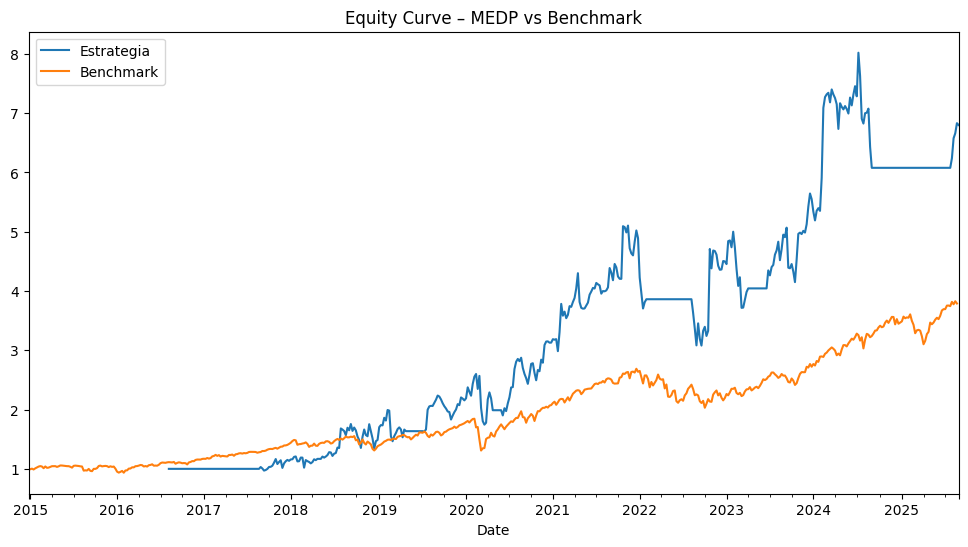

In [12]:
#Celda 10
# Elegir el primer ticker con resultados y graficar
# Use results from Cell 11 (simple_strategy_results)
if simple_strategy_results:
    # Find the first ticker with valid data in simple_strategy_results
    first_ticker = None
    for t in tickers:
        if t in simple_strategy_results and 'data' in simple_strategy_results[t]:
             first_ticker = t
             break

    if first_ticker:
        df = simple_strategy_results[first_ticker]['data']
        # plot_score(df, first_ticker) # This plot is for Stan Weinstein score, not applicable to simple SMA
        plot_equity_vs_benchmark(simple_strategy_results[first_ticker]['equity'], simple_strategy_results[first_ticker]['bench_equity'], first_ticker)
        # plot_base_breakout(df, first_ticker, window=60) # This plot is for Stan Weinstein base/breakout, not applicable

    else:
        print("No se encontraron tickers con datos procesados en simple_strategy_results para graficar.")
else:
    print("No hay resultados en simple_strategy_results para graficar.")

### Ejecutando la Estrategia Simple de Cruce SMA (Función `run_strategy`)

Este bloque de código llama a la función `run_strategy` definida en la celda 7 con un subconjunto de tus tickers para demostrar la salida que produce.

In [14]:
# Celda 11 - Imprimir resultados de la estartegia aplicada

# Ejemplo de ejecución de la función run_strategy definida en la celda 7
# Nota: Esta es la estrategia simple de cruce SMA, NO la estrategia Stan Weinstein actual de la celda 9.

# Importar la función si es necesario (ya está definida en el kernel)
# from __main__ import run_strategy # No es necesario si ya se ejecutó la celda 7

# Definir tickers y rango de fechas de ejemplo, usando los mismos parámetros que en la celda 9
tickers_example = tickers # Usar la lista completa de tickers de la celda 9
benchmark_example = benchmark # Usar el benchmark de la celda 9
start_example = start # Usar la fecha de inicio de la celda 9
end_example = end # Usar la fecha de fin de la celda 9


print(f"Ejecutando run_strategy para {len(tickers_example)} tickers desde {start_example} hasta {end_example} usando benchmark {benchmark_example}")

# Llamar a la función run_strategy
simple_strategy_results = run_strategy(tickers_example, benchmark=benchmark_example, start=start_example, end=end_example)

# Mostrar los resultados detallados por ticker
# print("\n--- Detalles de los cálculos por ticker (Estrategia Simple SMA) ---")
# for ticker, res in simple_strategy_results.items():
#     # La función run_strategy no devuelve el DataFrame completo, solo métricas y trades.
#     # Para mostrar los cálculos intermedios, necesitamos modificar run_strategy
#     # para que devuelva el DataFrame 'data' o replicar los cálculos aquí.

#     # Opción 1: Replicar los cálculos para ilustración (si no queremos modificar run_strategy)
#     # Descargar datos nuevamente (solo para ilustración de los calculos)
#     try:
#         data_illustrate = yf.download(ticker, start=start_example, end=end_example, interval='1wk', auto_adjust=True, progress=False)
#         if not data_illustrate.empty:
#              # Replicar calculos de SMA y Posicion
#             data_illustrate['SMA10'] = data_illustrate['Close'].rolling(10).mean()
#             data_illustrate['SMA30'] = data_illustrate['Close'].rolling(30).mean()
#             data_illustrate['Position'] = np.where(data_illustrate['SMA10'] > data_illustrate['SMA30'], 1, 0)
#             data_illustrate['Returns'] = data_illustrate['Close'].pct_change()
#             data_illustrate['Strategy_Returns'] = data_illustrate['Returns'] * data_illustrate['Position'].shift(1)

#             print(f"\nDetalles para {ticker}:")
#             # Mostrar las columnas relevantes de las últimas filas
#             display(data_illustrate[['Close', 'SMA10', 'SMA30', 'Position', 'Returns', 'Strategy_Returns']].tail())
#         else:
#             print(f"\nNo se pudieron descargar datos para ilustrar los cálculos de {ticker}")
#     except Exception as e:
#         print(f"\nError al ilustrar los cálculos para {ticker}: {e}")
#         continue


# Mostrar la tabla resumen final (como antes)
print("\n--- Tabla resumen de resultados (Estrategia Simple SMA) ---")
results_summary_list = []
for ticker, res in simple_strategy_results.items():
    row = {'Ticker': ticker}
    metrics = res.get('metrics', {})
    bench_metrics = res.get('bench_metrics', {})
    trades = res.get('trades', 0) # Get the trade count

    if metrics and bench_metrics:
        row.update(metrics)
        row.update({f'Bench_{k}': v for k, v in bench_metrics.items()})
        row['N_Trades'] = trades # Use the actual trade count
        results_summary_list.append(row)
    else:
         print(f"⚠️ {ticker}: No se obtuvieron métricas válidas con la estrategia simple (probablemente sin datos).")

if results_summary_list:
    simple_strategy_summary_df = pd.DataFrame(results_summary_list).set_index('Ticker')

    # Calculate a simple performance rank
    # Rank by CAGR (higher is better) and then Sharpe (higher is better)
    # Fill NaN values for ranking purposes, e.g., with a value lower than any possible actual metric
    rank_df = simple_strategy_summary_df[['CAGR', 'Sharpe', 'MaxDD']].fillna({'CAGR': -np.inf, 'Sharpe': -np.inf, 'MaxDD': np.inf})

    # Rank based on CAGR (descending), Sharpe (descending), and MaxDD (ascending - smaller drawdown is better)
    # Use method='min' to assign the same rank to ties
    rank_df['CAGR_Rank'] = rank_df['CAGR'].rank(method='min', ascending=False)
    rank_df['Sharpe_Rank'] = rank_df['Sharpe'].rank(method='min', ascending=False)
    rank_df['MaxDD_Rank'] = rank_df['MaxDD'].rank(method='min', ascending=True) # Ascending for MaxDD

    # Create a composite score (lower is better) - simple sum of ranks
    rank_df['Composite_Rank_Score'] = rank_df['CAGR_Rank'] + rank_df['Sharpe_Rank'] + rank_df['MaxDD_Rank']

    # Final Rank based on the composite score
    simple_strategy_summary_df['Performance_Rank'] = rank_df['Composite_Rank_Score'].rank(method='min', ascending=True).astype(int)

    # Sort by the new rank column for better visualization
    simple_strategy_summary_df = simple_strategy_summary_df.sort_values(by='Performance_Rank')

    display(simple_strategy_summary_df)
else:
    print("No se obtuvieron resultados de run_strategy para los tickers de ejemplo.")

Ejecutando run_strategy para 39 tickers desde 2015-01-01 hasta 2025-09-03 usando benchmark SPY


Processing tickers:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)



Debugging data before returning for MEDP:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-08-04,6.2398
2025-08-11,6.5774
2025-08-18,6.6606
2025-08-25,6.8311
2025-09-01,6.7999


Strategy Returns Tail:


,Strategy
Date,
2025-08-04,0.0266
2025-08-11,0.0541
2025-08-18,0.0126
2025-08-25,0.0256
2025-09-01,-0.0046


Processing tickers:   3%|▎         | 1/39 [00:00<00:29,  1.30it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.2340409774970693), 'Sharpe': np.float64(0.7443503075665001), 'MaxDD': -0.3966493697363659, 'TotalReturn': np.float64(5.799927125957121)}

Debugging data before returning for TBBK:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-07-31,1.5979
2025-08-07,1.7326
2025-08-14,1.6924
2025-08-21,1.9577
2025-08-28,1.9345


Strategy Returns Tail:


,Strategy
Date,
2025-07-31,-0.0037
2025-08-07,0.0843
2025-08-14,-0.0232
2025-08-21,0.1568
2025-08-28,-0.0118


Processing tickers:   5%|▌         | 2/39 [00:01<00:30,  1.23it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.06353891130633871), 'Sharpe': np.float64(0.38280855642024236), 'MaxDD': -0.7361827557688514, 'TotalReturn': np.float64(0.9345051963700435)}

Debugging data before returning for PODD:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-07-31,3.9141
2025-08-07,4.3570
2025-08-14,4.7003
2025-08-21,4.7194
2025-08-28,4.8686


Strategy Returns Tail:


,Strategy
Date,
2025-07-31,-0.0703
2025-08-07,0.1132
2025-08-14,0.0788
2025-08-21,0.0041
2025-08-28,0.0316


Processing tickers:   8%|▊         | 3/39 [00:02<00:30,  1.20it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.15924106157266715), 'Sharpe': np.float64(0.608688192313022), 'MaxDD': -0.438104224185517, 'TotalReturn': np.float64(3.8685502258523936)}


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)



Debugging data before returning for HG:
Strategy Equity Tail:


,Equity
Date,
2025-08-04,1.0000
2025-08-11,1.0000
2025-08-18,1.0000
2025-08-25,1.0000
2025-09-01,1.0000


Strategy Returns Tail:


,Strategy
Date,
2025-08-04,0.0000
2025-08-11,0.0000
2025-08-18,0.0000
2025-08-25,-0.0000
2025-09-01,-0.0000


Processing tickers:  10%|█         | 4/39 [00:02<00:20,  1.69it/s]

Metrics Dictionary:
{'CAGR': np.float64(0.0), 'Sharpe': nan, 'MaxDD': 0.0, 'TotalReturn': np.float64(0.0)}

Debugging data before returning for HNGE:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)
/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-08-04,1.0000
2025-08-11,1.0000
2025-08-18,1.0000
2025-08-25,1.0000
2025-09-01,1.0000


Strategy Returns Tail:


,Strategy
Date,
2025-08-04,0.0000
2025-08-11,0.0000
2025-08-18,-0.0000
2025-08-25,-0.0000
2025-09-01,-0.0000


Processing tickers:  13%|█▎        | 5/39 [00:02<00:14,  2.37it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.0), 'Sharpe': nan, 'MaxDD': 0.0, 'TotalReturn': np.float64(0.0)}

Debugging data before returning for AMSC:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-07-31,8.6755
2025-08-07,8.5521
2025-08-14,7.6067
2025-08-21,8.2391
2025-08-28,7.7094


Strategy Returns Tail:


,Strategy
Date,
2025-07-31,0.2487
2025-08-07,-0.0142
2025-08-14,-0.1106
2025-08-21,0.0831
2025-08-28,-0.0643


Processing tickers:  15%|█▌        | 6/39 [00:04<00:22,  1.44it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.2100684444088723), 'Sharpe': np.float64(0.6051376467160401), 'MaxDD': -0.7423628890586815, 'TotalReturn': np.float64(6.7094218771491825)}

Debugging data before returning for KNSA:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-08-04,1.0726
2025-08-11,1.1137
2025-08-18,1.1260
2025-08-25,1.1173
2025-09-01,1.1437


Strategy Returns Tail:


,Strategy
Date,
2025-08-04,0.0053
2025-08-11,0.0383
2025-08-18,0.0111
2025-08-25,-0.0077
2025-09-01,0.0236


Processing tickers:  18%|█▊        | 7/39 [00:05<00:25,  1.27it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.01849249726598856), 'Sharpe': np.float64(0.23229506888918636), 'MaxDD': -0.6382615238223552, 'TotalReturn': np.float64(0.14368503490387674)}

Debugging data before returning for ALAB:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-08-04,1.0745
2025-08-11,1.1138
2025-08-18,1.0733
2025-08-25,1.0920
2025-09-01,1.0443


Strategy Returns Tail:


,Strategy
Date,
2025-08-04,0.3675
2025-08-11,0.0366
2025-08-18,-0.0364
2025-08-25,0.0174
2025-09-01,-0.0437


Processing tickers:  21%|██        | 8/39 [00:05<00:19,  1.57it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.029674939862346816), 'Sharpe': np.float64(0.2981630473151889), 'MaxDD': -0.5705504182609529, 'TotalReturn': np.float64(0.044253599786335585)}

Debugging data before returning for ALNT:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-07-31,0.7119
2025-08-07,0.8194
2025-08-14,0.7656
2025-08-21,0.8388
2025-08-28,0.8029


Strategy Returns Tail:


,Strategy
Date,
2025-07-31,0.0129
2025-08-07,0.1511
2025-08-14,-0.0656
2025-08-21,0.0955
2025-08-28,-0.0427


Processing tickers:  23%|██▎       | 9/39 [00:06<00:24,  1.23it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(-0.02028108010650198), 'Sharpe': np.float64(0.12806317002015402), 'MaxDD': -0.7092093700825574, 'TotalReturn': np.float64(-0.19705957827783271)}

Debugging data before returning for FNV:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-07-31,2.7495
2025-08-07,2.8795
2025-08-14,2.8667
2025-08-21,2.9864
2025-08-28,3.0605


Strategy Returns Tail:


,Strategy
Date,
2025-07-31,0.0832
2025-08-07,0.0473
2025-08-14,-0.0045
2025-08-21,0.0418
2025-08-28,0.0248


Processing tickers:  26%|██▌       | 10/39 [00:07<00:26,  1.10it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.11007508737939742), 'Sharpe': np.float64(0.5642840315249666), 'MaxDD': -0.37836040164851403, 'TotalReturn': np.float64(2.06050792055164)}

Debugging data before returning for PRM:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-08-04,2.5071
2025-08-11,2.5851
2025-08-18,2.7132
2025-08-25,3.1185
2025-09-01,3.1366


Strategy Returns Tail:


,Strategy
Date,
2025-08-04,0.1509
2025-08-11,0.0311
2025-08-18,0.0496
2025-08-25,0.1494
2025-09-01,0.0058


Processing tickers:  28%|██▊       | 11/39 [00:08<00:20,  1.34it/s]

Metrics Dictionary:
{'CAGR': np.float64(0.34610703793392195), 'Sharpe': np.float64(1.301965912018778), 'MaxDD': -0.2841804002250863, 'TotalReturn': np.float64(2.1366060832743234)}

Debugging data before returning for ARX:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)
/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-08-04,1.0000
2025-08-11,1.0000
2025-08-18,1.0000
2025-08-25,1.0000
2025-09-01,1.0000


Strategy Returns Tail:


,Strategy
Date,
2025-08-04,0.0000
2025-08-11,0.0000
2025-08-18,0.0000
2025-08-25,-0.0000
2025-09-01,0.0000


Processing tickers:  31%|███       | 12/39 [00:08<00:15,  1.79it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.0), 'Sharpe': nan, 'MaxDD': 0.0, 'TotalReturn': np.float64(0.0)}

Debugging data before returning for STX:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-07-31,4.1732
2025-08-07,4.4466
2025-08-14,4.4886
2025-08-21,4.7391
2025-08-28,4.8314


Strategy Returns Tail:


,Strategy
Date,
2025-07-31,-0.0010
2025-08-07,0.0655
2025-08-14,0.0094
2025-08-21,0.0558
2025-08-28,0.0195


Processing tickers:  33%|███▎      | 13/39 [00:09<00:17,  1.52it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.15841306458856552), 'Sharpe': np.float64(0.6907140214587302), 'MaxDD': -0.42880434314795524, 'TotalReturn': np.float64(3.831430841308743)}

Debugging data before returning for RMBS:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-07-31,2.3420
2025-08-07,2.5131
2025-08-14,2.2804
2025-08-21,2.4562
2025-08-28,2.4051


Strategy Returns Tail:


,Strategy
Date,
2025-07-31,-0.0470
2025-08-07,0.0731
2025-08-14,-0.0926
2025-08-21,0.0771
2025-08-28,-0.0208


Processing tickers:  36%|███▌      | 14/39 [00:09<00:17,  1.39it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.08538055710150205), 'Sharpe': np.float64(0.42670618058906223), 'MaxDD': -0.42103000091368814, 'TotalReturn': np.float64(1.405128941669933)}

Debugging data before returning for KGC:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-07-31,6.6314
2025-08-07,6.7519
2025-08-14,6.7625
2025-08-21,7.1630
2025-08-28,7.6180


Strategy Returns Tail:


,Strategy
Date,
2025-07-31,0.2134
2025-08-07,0.0182
2025-08-14,0.0016
2025-08-21,0.0592
2025-08-28,0.0635


Processing tickers:  38%|███▊      | 15/39 [00:10<00:18,  1.31it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.20872209056668733), 'Sharpe': np.float64(0.6991099864635152), 'MaxDD': -0.5132407184833094, 'TotalReturn': np.float64(6.618036261393014)}

Debugging data before returning for URBN:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-07-31,2.3534
2025-08-07,2.3446
2025-08-14,2.1641
2025-08-21,2.3009
2025-08-28,1.9942


Strategy Returns Tail:


,Strategy
Date,
2025-07-31,0.0457
2025-08-07,-0.0038
2025-08-14,-0.0770
2025-08-21,0.0632
2025-08-28,-0.1333


Processing tickers:  41%|████      | 16/39 [00:11<00:18,  1.27it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.06656024923158976), 'Sharpe': np.float64(0.3611186521772999), 'MaxDD': -0.6304605214336092, 'TotalReturn': np.float64(0.9941903872739104)}

Debugging data before returning for BAP:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-07-31,1.2825
2025-08-07,1.3161
2025-08-14,1.3145
2025-08-21,1.3317
2025-08-28,1.3728


Strategy Returns Tail:


,Strategy
Date,
2025-07-31,0.0336
2025-08-07,0.0263
2025-08-14,-0.0012
2025-08-21,0.0131
2025-08-28,0.0308


Processing tickers:  44%|████▎     | 17/39 [00:12<00:17,  1.24it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.030022987434419113), 'Sharpe': np.float64(0.2472156183917435), 'MaxDD': -0.6204925178897716, 'TotalReturn': np.float64(0.3728094087717426)}

Debugging data before returning for EGO:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-07-31,2.8005
2025-08-07,2.7211
2025-08-14,2.7139
2025-08-21,2.9182
2025-08-28,3.0565


Strategy Returns Tail:


,Strategy
Date,
2025-07-31,0.1377
2025-08-07,-0.0283
2025-08-14,-0.0027
2025-08-21,0.0753
2025-08-28,0.0474


Processing tickers:  46%|████▌     | 18/39 [00:13<00:17,  1.22it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.10993811368847894), 'Sharpe': np.float64(0.4662485782262059), 'MaxDD': -0.44554132842732674, 'TotalReturn': np.float64(2.0564652349751276)}

Debugging data before returning for WDC:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-07-31,1.5685
2025-08-07,1.6171
2025-08-14,1.6080
2025-08-21,1.7149
2025-08-28,1.7413


Strategy Returns Tail:


,Strategy
Date,
2025-07-31,0.0329
2025-08-07,0.0310
2025-08-14,-0.0057
2025-08-21,0.0665
2025-08-28,0.0154


Processing tickers:  49%|████▊     | 19/39 [00:14<00:16,  1.21it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.0531429069198488), 'Sharpe': np.float64(0.3243942906968446), 'MaxDD': -0.6154725020775925, 'TotalReturn': np.float64(0.7413002183038362)}

Debugging data before returning for HOOD:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-08-04,6.1904
2025-08-11,6.1656
2025-08-18,5.9037
2025-08-25,5.6180
2025-09-01,5.4457


Strategy Returns Tail:


,Strategy
Date,
2025-08-04,0.1474
2025-08-11,-0.0040
2025-08-18,-0.0425
2025-08-25,-0.0484
2025-09-01,-0.0307


Processing tickers:  51%|█████▏    | 20/39 [00:14<00:13,  1.43it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.5066848043535652), 'Sharpe': np.float64(1.0777700652295756), 'MaxDD': -0.49132985953467034, 'TotalReturn': np.float64(4.445705958295776)}

Debugging data before returning for APH:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-07-31,2.7272
2025-08-07,2.7355
2025-08-14,2.7061
2025-08-21,2.7429
2025-08-28,2.7210


Strategy Returns Tail:


,Strategy
Date,
2025-07-31,0.0380
2025-08-07,0.0030
2025-08-14,-0.0107
2025-08-21,0.0136
2025-08-28,-0.0080


Processing tickers:  54%|█████▍    | 21/39 [00:15<00:13,  1.34it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.09795708262156477), 'Sharpe': np.float64(0.5921324619497621), 'MaxDD': -0.4731667598520679, 'TotalReturn': np.float64(1.721019747224148)}

Debugging data before returning for RKLB:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-08-04,2.6110
2025-08-11,2.5865
2025-08-18,2.5929
2025-08-25,2.8395
2025-09-01,2.8810


Strategy Returns Tail:


,Strategy
Date,
2025-08-04,-0.0027
2025-08-11,-0.0094
2025-08-18,0.0025
2025-08-25,0.0951
2025-09-01,0.0146


Processing tickers:  56%|█████▋    | 22/39 [00:15<00:11,  1.52it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.24618984606102612), 'Sharpe': np.float64(0.6570395525117593), 'MaxDD': -0.6906360456132401, 'TotalReturn': np.float64(1.8809748232814063)}

Debugging data before returning for EXTR:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-07-31,2.7651
2025-08-07,2.8283
2025-08-14,2.7295
2025-08-21,2.9518
2025-08-28,2.9600


Strategy Returns Tail:


,Strategy
Date,
2025-07-31,0.1263
2025-08-07,0.0228
2025-08-14,-0.0349
2025-08-21,0.0814
2025-08-28,0.0028


Processing tickers:  59%|█████▉    | 23/39 [00:16<00:11,  1.41it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.10662015205929443), 'Sharpe': np.float64(0.4644720408385125), 'MaxDD': -0.6237327023584549, 'TotalReturn': np.float64(1.9600048634627947)}

Debugging data before returning for NVDA:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-07-31,389.6829
2025-08-07,394.3959
2025-08-14,380.9518
2025-08-21,394.4176
2025-08-28,370.9176


Strategy Returns Tail:


,Strategy
Date,
2025-07-31,0.0008
2025-08-07,0.0121
2025-08-14,-0.0341
2025-08-21,0.0353
2025-08-28,-0.0596


Processing tickers:  62%|██████▏   | 24/39 [00:17<00:11,  1.28it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.7372436553232318), 'Sharpe': np.float64(1.583435033803846), 'MaxDD': -0.42018330545395055, 'TotalReturn': np.float64(369.9176335108152)}

Debugging data before returning for TFPM:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-08-04,1.4811
2025-08-11,1.4615
2025-08-18,1.4744
2025-08-25,1.5320
2025-09-01,1.5505


Strategy Returns Tail:


,Strategy
Date,
2025-08-04,0.1484
2025-08-11,-0.0132
2025-08-18,0.0088
2025-08-25,0.0391
2025-09-01,0.0121


Processing tickers:  64%|██████▍   | 25/39 [00:18<00:09,  1.46it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.15527344943105637), 'Sharpe': np.float64(0.7302768237694671), 'MaxDD': -0.16979510911424345, 'TotalReturn': np.float64(0.5504770097911038)}

Debugging data before returning for ANET:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-07-31,14.2619
2025-08-07,14.1828
2025-08-14,13.5107
2025-08-21,13.6957
2025-08-28,13.9629


Strategy Returns Tail:


,Strategy
Date,
2025-07-31,0.1367
2025-08-07,-0.0055
2025-08-14,-0.0474
2025-08-21,0.0137
2025-08-28,0.0195


Processing tickers:  67%|██████▋   | 26/39 [00:19<00:10,  1.21it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.279062436333245), 'Sharpe': np.float64(0.9072761374096533), 'MaxDD': -0.41624574274824333, 'TotalReturn': np.float64(12.96288093377406)}

Debugging data before returning for ATAT:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-08-04,1.0521
2025-08-11,1.0375
2025-08-18,1.0628
2025-08-25,1.1577
2025-09-01,1.1491


Strategy Returns Tail:


,Strategy
Date,
2025-08-04,0.0571
2025-08-11,-0.0139
2025-08-18,0.0244
2025-08-25,0.0893
2025-09-01,-0.0075


Processing tickers:  69%|██████▉   | 27/39 [00:19<00:08,  1.39it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.050029427674761706), 'Sharpe': np.float64(0.32332314412452934), 'MaxDD': -0.28950740451419554, 'TotalReturn': np.float64(0.1490598423336702)}

Debugging data before returning for FIX:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-07-31,4.4279
2025-08-07,4.5026
2025-08-14,4.3678
2025-08-21,4.5554
2025-08-28,4.4834


Strategy Returns Tail:


,Strategy
Date,
2025-07-31,-0.0178
2025-08-07,0.0169
2025-08-14,-0.0299
2025-08-21,0.0430
2025-08-28,-0.0158


Processing tickers:  72%|███████▏  | 28/39 [00:20<00:09,  1.20it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.150357124031969), 'Sharpe': np.float64(0.6085912007525046), 'MaxDD': -0.57263754821905, 'TotalReturn': np.float64(3.4834430725085577)}

Debugging data before returning for OUST:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-08-04,0.1578
2025-08-11,0.2123
2025-08-18,0.1874
2025-08-25,0.1744
2025-09-01,0.1709


Strategy Returns Tail:


,Strategy
Date,
2025-08-04,0.1738
2025-08-11,0.3457
2025-08-18,-0.1172
2025-08-25,-0.0692
2025-09-01,-0.0203


Processing tickers:  74%|███████▍  | 29/39 [00:21<00:07,  1.38it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(-0.3005483663601125), 'Sharpe': np.float64(-0.3473661383906039), 'MaxDD': -0.8934727151124716, 'TotalReturn': np.float64(-0.8290989498276151)}

Debugging data before returning for WGS:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-08-04,9.0381
2025-08-11,9.0381
2025-08-18,9.2029
2025-08-25,9.2619
2025-09-01,9.1682


Strategy Returns Tail:


,Strategy
Date,
2025-08-04,0.0000
2025-08-11,0.0000
2025-08-18,0.0182
2025-08-25,0.0064
2025-09-01,-0.0101


Processing tickers:  77%|███████▋  | 30/39 [00:21<00:05,  1.55it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.576820218839619), 'Sharpe': np.float64(1.0142098373221506), 'MaxDD': -0.4672552179841204, 'TotalReturn': np.float64(8.168248500139532)}

Debugging data before returning for LMND:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-08-04,0.8047
2025-08-11,0.9425
2025-08-18,0.9335
2025-08-25,0.8691
2025-09-01,0.8507


Strategy Returns Tail:


,Strategy
Date,
2025-08-04,0.3456
2025-08-11,0.1713
2025-08-18,-0.0096
2025-08-25,-0.0690
2025-09-01,-0.0212


Processing tickers:  79%|███████▉  | 31/39 [00:22<00:04,  1.68it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)
/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(-0.030549784730699803), 'Sharpe': np.float64(0.14731585257733837), 'MaxDD': -0.6621282081335311, 'TotalReturn': np.float64(-0.1492985275942592)}

Debugging data before returning for LIF:
Strategy Equity Tail:


,Equity
Date,
2025-08-04,1.1621
2025-08-11,1.3443
2025-08-18,1.4197
2025-08-25,1.4232
2025-09-01,1.3704


Strategy Returns Tail:


,Strategy
Date,
2025-08-04,-0.0074
2025-08-11,0.1568
2025-08-18,0.0561
2025-08-25,0.0025
2025-09-01,-0.0371


Processing tickers:  82%|████████▏ | 32/39 [00:22<00:03,  2.09it/s]

Metrics Dictionary:
{'CAGR': np.float64(0.2818091199128767), 'Sharpe': np.float64(1.252125604625269), 'MaxDD': -0.04322628641333248, 'TotalReturn': np.float64(0.3704169533192103)}

Debugging data before returning for RDDT:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)
/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-08-04,1.1421
2025-08-11,1.3067
2025-08-18,1.1520
2025-08-25,1.1932
2025-09-01,1.1666


Strategy Returns Tail:


,Strategy
Date,
2025-08-04,0.1421
2025-08-11,0.1442
2025-08-18,-0.1184
2025-08-25,0.0358
2025-09-01,-0.0223


Processing tickers:  85%|████████▍ | 33/39 [00:22<00:02,  2.53it/s]

Metrics Dictionary:
{'CAGR': np.float64(0.10964526023696108), 'Sharpe': np.float64(0.6317436540327542), 'MaxDD': -0.11841785980286512, 'TotalReturn': np.float64(0.166560635446384)}


/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)



Debugging data before returning for ARQT:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-08-04,1.1454
2025-08-11,1.3098
2025-08-18,1.2396
2025-08-25,1.2035
2025-09-01,1.1880


Strategy Returns Tail:


,Strategy
Date,
2025-08-04,0.0336
2025-08-11,0.1435
2025-08-18,-0.0536
2025-08-25,-0.0291
2025-09-01,-0.0129


Processing tickers:  87%|████████▋ | 34/39 [00:23<00:02,  2.34it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.03104980126889978), 'Sharpe': np.float64(0.2827248913578466), 'MaxDD': -0.5278709178145531, 'TotalReturn': np.float64(0.18802527433851712)}

Debugging data before returning for TARS:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-08-04,1.1285
2025-08-11,1.1285
2025-08-18,1.1285
2025-08-25,1.1285
2025-09-01,1.1285


Strategy Returns Tail:


,Strategy
Date,
2025-08-04,0.0000
2025-08-11,0.0000
2025-08-18,0.0000
2025-08-25,0.0000
2025-09-01,0.0000


Processing tickers:  90%|████████▉ | 35/39 [00:23<00:01,  2.30it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.024852268138306766), 'Sharpe': np.float64(0.24996082251601884), 'MaxDD': -0.48944892686048824, 'TotalReturn': np.float64(0.12846017186529513)}

Debugging data before returning for MIRM:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-08-04,1.5347
2025-08-11,1.7384
2025-08-18,1.8303
2025-08-25,1.8904
2025-09-01,1.9025


Strategy Returns Tail:


,Strategy
Date,
2025-08-04,0.1528
2025-08-11,0.1327
2025-08-18,0.0528
2025-08-25,0.0329
2025-09-01,0.0064


Processing tickers:  92%|█████████▏| 36/39 [00:24<00:01,  2.12it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.10980829287111149), 'Sharpe': np.float64(0.4924971461536564), 'MaxDD': -0.3930058700010084, 'TotalReturn': np.float64(0.9024759387483483)}

Debugging data before returning for HSAI:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-08-04,4.5161
2025-08-11,5.1069
2025-08-18,4.6419
2025-08-25,5.1428
2025-09-01,4.9931


Strategy Returns Tail:


,Strategy
Date,
2025-08-04,0.2082
2025-08-11,0.1308
2025-08-18,-0.0911
2025-08-25,0.1079
2025-09-01,-0.0291


Processing tickers:  95%|█████████▍| 37/39 [00:24<00:00,  2.38it/s]/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)


Metrics Dictionary:
{'CAGR': np.float64(0.8578130480828197), 'Sharpe': np.float64(1.1926665593793344), 'MaxDD': -0.4469696852932432, 'TotalReturn': np.float64(3.9931038587046297)}

Debugging data before returning for ONC:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-08-04,6.2475
2025-08-11,6.9668
2025-08-18,6.8001
2025-08-25,6.6349
2025-09-01,7.1983


Strategy Returns Tail:


,Strategy
Date,
2025-08-04,-0.0362
2025-08-11,0.1151
2025-08-18,-0.0239
2025-08-25,-0.0243
2025-09-01,0.0849


Processing tickers:  97%|█████████▋| 38/39 [00:25<00:00,  1.88it/s]

Metrics Dictionary:
{'CAGR': np.float64(0.2273664277613796), 'Sharpe': np.float64(0.6680908066545317), 'MaxDD': -0.5949260852106961, 'TotalReturn': np.float64(6.198343712025358)}

Debugging data before returning for KRMN:
Strategy Equity Tail:


/tmp/ipython-input-3812190965.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval='1wk', progress=False)
/tmp/ipython-input-3812190965.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench = yf.download(benchmark, start=start, end=end, interval='1wk', progress=False)


,Equity
Date,
2025-08-04,1.0000
2025-08-11,1.0000
2025-08-18,1.0000
2025-08-25,1.0000
2025-09-01,1.0000


Strategy Returns Tail:


,Strategy
Date,
2025-08-04,-0.0000
2025-08-11,0.0000
2025-08-18,0.0000
2025-08-25,0.0000
2025-09-01,0.0000


Processing tickers: 100%|██████████| 39/39 [00:25<00:00,  1.53it/s]

Metrics Dictionary:
{'CAGR': np.float64(0.0), 'Sharpe': nan, 'MaxDD': 0.0, 'TotalReturn': np.float64(0.0)}

--- Tabla resumen de resultados (Estrategia Simple SMA) ---


,CAGR,Sharpe,MaxDD,TotalReturn,Bench_CAGR,Bench_Sharpe,Bench_MaxDD,Bench_TotalReturn,N_Trades,Performance_Rank
Ticker,,,,,,,,,,
RKLB,0.2462,0.6570,-0.6906,1.8810,0.1324,0.8662,-0.2907,2.7894,5,1
HOOD,0.5067,1.0778,-0.4913,4.4457,0.1324,0.8662,-0.2907,2.7894,4,1
HSAI,0.8578,1.1927,-0.4470,3.9931,0.1324,0.8662,-0.2907,2.7894,2,1
WGS,0.5768,1.0142,-0.4673,8.1682,0.1324,0.8662,-0.2907,2.7894,2,4
NVDA,0.7372,1.5834,-0.4202,369.9176,0.1324,0.8662,-0.2907,2.7894,5,4
AMSC,0.2101,0.6051,-0.7424,6.7094,0.1324,0.8662,-0.2907,2.7894,10,6
ONC,0.2274,0.6681,-0.5949,6.1983,0.1324,0.8662,-0.2907,2.7894,10,7
KGC,0.2087,0.6991,-0.5132,6.6180,0.1324,0.8662,-0.2907,2.7894,12,8
PRM,0.3461,1.3020,-0.2842,2.1366,0.1324,0.8662,-0.2907,2.7894,2,9


#El objetivo del backtest es medir:

1. CAGR_Strategy → crecimiento anual compuesto si hubieras seguido la estrategia. Bueno si es mayor al benchmark (SPY u otro índice).

Ejemplo: Estrategia CAGR = 18%. Benchmark CAGR = 10% → Tu sistema le gana al mercado.

2. Sharpe_Strategy → ratio riesgo/retorno.
Regla práctica:
    Sharpe < 1 → pobre.
    1 ≤ Sharpe < 2 → aceptable.
    2 ≤ Sharpe < 3 → muy bueno. 3 → excelente

3. MaxDD_Strategy → drawdown máximo (la peor caída desde un pico). Bueno si es menor al benchmark.

3. TotalReturn_Strategy → retorno total.

4. N_Trades → cuántas operaciones ejecutó la estrategia.

👉 Si N_Trades = 0, significa que las reglas nunca se activaron. Entonces esa estrategia no puede evaluarse porque no generó operaciones.

# ¿Cómo interpretarlo?

Si un ticker muestra CAGR_Strategy > CAGR_Bench, la estrategia logró “ganar al mercado”.

Un Sharpe > 1 ya es aceptable, > 2 excelente.

MaxDD bajo (ej. < -20%) indica mejor control de pérdidas.

N_Trades bajo pero con buena CAGR = sistema selectivo pero potente.

En gráficos, confirma que el score subió a ≥8 en bases sólidas y que la salida se dio al deteriorarse la WMA30 (fase 3).

6. Equity Curve vs Benchmark: La curva del capital (estrategia) debería ser más suave, consistente y ascendente que la del benchmark.Si tu curva es muy parecida al benchmark pero con más volatilidad → la estrategia no aporta valor.